In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
import sklearn.metrics

from collections import Counter
import csv
from glob import glob
import io
import json
import pickle
import operator

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13, 
                     'axes.labelcolor': 'limegreen',
                     'xtick.color': 'limegreen',
                     'ytick.color': 'limegreen'
                    })

# Build training set

In [2]:
def basepaths(year_from=2011, year_to=2020, path="../data/sociopol/train"):
    for y in range(year_from, year_to):
        for m in range(1, 13):
            yield y, m, "%s/%d-%02d" % (path, y, m)

In [3]:
def parse_dataset(*a, **kw):
    path2pos = {}
    path2neg = {}
    for y, m, path in tqdm(list(basepaths(*a, **kw))):
        pos = []
        with open(f"{path}-positive.txt") as f:
            for line in f:
                sub, text = line.strip().split("\t", 1)
                pos.append(text)
        path2pos[(y, m)] = pos

        neg = []
        with open(f"{path}-negative.txt") as f:
            for line in f:
                neg.append(line.strip())
                if len(neg) >= len(pos):
                    break
        path2neg[(y, m)] = neg

    pos = [l for p in path2pos.values() for l in p]
    neg = [l for p in path2neg.values() for l in p]
    return path2pos, path2neg, pos, neg

In [4]:
_, _, pos, neg = parse_dataset(path="../data/sociopol/train")

In [11]:
len(pos), len(neg)

(104292, 104292)

In [6]:
training_set = [(l, 1) for l in pos] + [(l, 0) for l in neg]
np.random.shuffle(training_set)

# Build feature matrix

In [7]:
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
import gensim.utils
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

In [8]:
import spacy

nlp = spacy.load('en')

from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups

lookups = Lookups()
for table in nlp.vocab.lookups.tables:
    lookups.add_table(table, nlp.vocab.lookups.get_table(table))
    
lemmatizer = Lemmatizer(lookups)

In [9]:
def process(t):
    t = gensim.utils.simple_preprocess(t)
    t = [lemmatizer.lookup(w) for w in t if w not in stop_words]
    return t

process("Hello my name is michael and i love videogames")

['hello', 'name', 'michael', 'love', 'videogame']

In [12]:
vectorizer = TfidfVectorizer(min_df=4,
                             tokenizer=lambda x: x, 
                             preprocessor=lambda x: x,
                             ngram_range=(1, 3),
                             max_features=10000,
                             max_df=0.75,
                            )
X = vectorizer.fit_transform(process(t) for t, y in tqdm(training_set))

In [13]:
np.random.choice(vectorizer.get_feature_names(), 100)

array(['distance', 'put', 'usd', 'inevitable', 'little girl', 'story',
       'motherboard asrock', 'can good', 'dawn', 'les', 'simply',
       'legislative', 'say thing like', 'education', 'origin',
       'https doc google', 'actually', 'anyone ever', 'clothe', 'tense',
       'titan', 'replay', 'stumble', 'password', 'conscience',
       'http steamcommunity', 'gpu', 'com search',
       'specific feature item', 'ak', 'http imgur', 'small business',
       'feel like', 'thing feel', 'bash', 'obsession', 'stumble',
       'motorcycle', 'forward', 'people use', 'every year',
       'wikipedia org', 'temporary', 'driveway', 'useful',
       'include specific', 'instinct', 'meeting', 'system', 'favor',
       'franchise', 'concentration', 'many different', 'optimistic',
       'can take', 'like would', 'employ', 'promotion', 'know know',
       'two three', 'make comment', 'partner amp', 'vent', 'well option',
       'socrates', 'make change', 'doubt', 'evaluation', 'technology',
      

In [14]:
X

<208584x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 25766622 stored elements in Compressed Sparse Row format>

In [15]:
Y = np.array([y for t, y in training_set])

# Train classifier
Takes 5 to 10 minutes

In [16]:
clf = LogisticRegression(random_state=0,
                         solver='saga', # saga or liblinear
                         class_weight='balanced',
                        penalty='l1',
                        verbose=1)
clf.fit(X, Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 534 seconds


/home/corradom/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.9min finished


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

## Evaluate classifier in-sample performance

In [17]:
Y_pred = clf.predict(X)

In [18]:
np.mean(Y_pred == Y)

0.9090102788325087

In [19]:
print(sklearn.metrics.classification_report(Y, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91    104292
           1       0.93      0.89      0.91    104292

    accuracy                           0.91    208584
   macro avg       0.91      0.91      0.91    208584
weighted avg       0.91      0.91      0.91    208584



# Evaluate classifier on test set

In [26]:
testpos, testneg, _, _ = parse_dataset(path="../data/sociopol/test")

In [27]:
keys = sorted(list(testpos.keys()))

ym2testset = dict()

for key in tqdm(keys):
    test_text = testpos[key] + testneg[key]
    Y_test = np.array([1] * len(testpos[key]) + [0] * len(testneg[key]))
    X_test = vectorizer.transform(process(t) for t in test_text)
    ym2testset[key] = (X_test, Y_test)

In [28]:
scores = []
for ym in tqdm(keys):
    X_test, Y_test = ym2testset[ym]
    scores.append(sklearn.metrics.accuracy_score(
            Y_test, clf.predict(X_test)
        ))

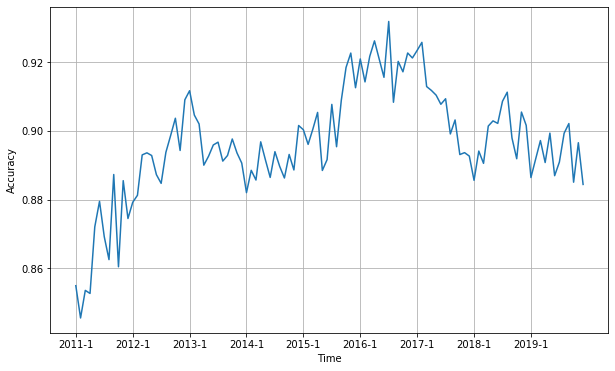

In [30]:
plt.rcParams.update({'font.size': 10, 
                     'axes.labelcolor': 'k',
                     'xtick.color': 'k',
                     'ytick.color': 'k'
                    })
plt.figure(figsize=(10, 6))
plt.plot([f"{y}-{m}" for y, m in keys], scores)
plt.grid()
plt.xticks([f"{y}-{m}" for y, m in keys[::12]])
plt.ylabel("Accuracy")
plt.xlabel("Time")
plt.savefig("../paper/fig/sociopol-test.pdf")

In [31]:
for y in range(2011, 2020):
    scores = []
    Y_test = []
    Y_pred = []
    for m in range(1, 13):
        X_test_ym, Y_test_ym = ym2testset[(y, m)]
        Y_test.append(Y_test_ym)
        Y_pred.append(clf.predict(X_test_ym))
        
    print(y, '\n', sklearn.metrics.classification_report(np.hstack(Y_test), np.hstack(Y_pred)))
    print('\n\n')

2011 
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      6955
           1       0.87      0.87      0.87      6955

    accuracy                           0.87     13910
   macro avg       0.87      0.87      0.87     13910
weighted avg       0.87      0.87      0.87     13910




2012 
               precision    recall  f1-score   support

           0       0.89      0.90      0.89     10142
           1       0.90      0.88      0.89     10142

    accuracy                           0.89     20284
   macro avg       0.89      0.89      0.89     20284
weighted avg       0.89      0.89      0.89     20284




2013 
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     11381
           1       0.92      0.87      0.89     11381

    accuracy                           0.90     22762
   macro avg       0.90      0.90      0.90     22762
weighted avg       0.90      0.90      0.90    

# Evaluate classifier on CMV validation posts

In [20]:
cmv_posts_labels = pd.read_csv("../data/cmv-posts-labels.tsv", sep='\t')

In [38]:
cmv_posts_labels.columns

Index(['URL', 'text', 'Title', 'Sociopolitical'], dtype='object')

In [22]:
cmv_posts_labels["Sociopolitical"] = ~cmv_posts_labels["Sociopolitical"].isna()

In [21]:
def classify(txt):
    tfidf = vectorizer.transform([process(txt)])
    return clf.predict(tfidf)[0] > 0

#### Results considering title and, if available, text

In [56]:
cmv_posts_labels["Predicted"] = [
    classify(x[0] + ' ' + (x[1] if isinstance(x[1], str) else '')) 
  for x in cmv_posts_labels[['Title', 'text']].values]

In [57]:
print(sklearn.metrics.classification_report(
    cmv_posts_labels["Sociopolitical"].values,
    cmv_posts_labels["Predicted"].values
))

              precision    recall  f1-score   support

       False       0.71      0.66      0.69       231
        True       0.73      0.77      0.75       269

    accuracy                           0.72       500
   macro avg       0.72      0.72      0.72       500
weighted avg       0.72      0.72      0.72       500



In [80]:
cmv_posts_labels["Predicted_only_title"] = [
    classify(x[0])
  for x in cmv_posts_labels[['Title', 'text']].values]

#### Results considering only title

In [82]:
print(sklearn.metrics.classification_report(
    cmv_posts_labels["Sociopolitical"].values,
    cmv_posts_labels["Predicted_only_title"].values
))

              precision    recall  f1-score   support

       False       0.69      0.68      0.68       231
        True       0.73      0.73      0.73       269

    accuracy                           0.71       500
   macro avg       0.71      0.71      0.71       500
weighted avg       0.71      0.71      0.71       500



### Let's consider only posts where text is still available

In [58]:
cmv_posts_labels["Predicted_only_text"] = [
    classify(x[1]) if isinstance(x[1], str) and x[1] not in ('[removed]', '[deleted]')
    else np.nan
  for x in cmv_posts_labels[['Title', 'text']].values]

In [62]:
valid = ~cmv_posts_labels["Predicted_only_text"].isna()

In [83]:
np.mean(valid), Counter(valid.values)

(0.412, Counter({True: 206, False: 294}))

In [84]:
Counter(cmv_posts_labels["Sociopolitical"].values)

Counter({True: 269, False: 231})

In [85]:
Counter(cmv_posts_labels[valid]["Sociopolitical"].values)

Counter({True: 120, False: 86})

#### Results considering title and text only on posts where text is available

In [71]:
print(sklearn.metrics.classification_report(
    cmv_posts_labels[valid]["Sociopolitical"].values,
    cmv_posts_labels[valid]["Predicted"].values
))

              precision    recall  f1-score   support

       False       0.79      0.60      0.68        86
        True       0.76      0.88      0.82       120

    accuracy                           0.77       206
   macro avg       0.77      0.74      0.75       206
weighted avg       0.77      0.77      0.76       206



#### Results considering only text, only on posts where text is available

In [79]:
print(sklearn.metrics.classification_report(
    cmv_posts_labels[valid]["Sociopolitical"].values,
    np.array(cmv_posts_labels[valid]["Predicted_only_text"].values, dtype=np.float)
))

              precision    recall  f1-score   support

       False       0.75      0.64      0.69        86
        True       0.77      0.85      0.81       120

    accuracy                           0.76       206
   macro avg       0.76      0.74      0.75       206
weighted avg       0.76      0.76      0.76       206



#### Results considering only title, only on posts where text is available

In [81]:
print(sklearn.metrics.classification_report(
    cmv_posts_labels[valid]["Sociopolitical"].values,
    cmv_posts_labels[valid]["Predicted_only_title"].values
))

              precision    recall  f1-score   support

       False       0.70      0.70      0.70        86
        True       0.78      0.78      0.78       120

    accuracy                           0.75       206
   macro avg       0.74      0.74      0.74       206
weighted avg       0.75      0.75      0.75       206



# Show most important features

In [32]:
import heapq

In [33]:
heapq.nlargest(50, vectorizer.vocabulary_.keys(), 
               key=lambda s: clf.coef_[0, vectorizer.vocabulary_[s]])

['trp',
 'smv',
 'peterson',
 'buddhism',
 'anarchist',
 'red pill',
 'libertarian',
 'askhistorians',
 'bernie',
 'anarchism',
 'buddhist',
 'mensrights',
 'conspiracy',
 'capitalism',
 'philosophy',
 'socialism',
 'historian',
 'ukpolitics',
 'feminist',
 'skeptic',
 'capitalist',
 'comrade',
 'geopolitics',
 'military',
 'shit test',
 'the_donald',
 'christianity',
 'philosopher',
 'buddha',
 'leftist',
 'christian',
 'philosophical',
 'socialist',
 'feminism',
 'live stream',
 'atheist',
 'lesson learn',
 'dharma',
 'bible',
 'leo',
 'firearm',
 'blue pill',
 'man right',
 'ltr',
 'trump',
 'prayer',
 'pray',
 'kryptocal',
 'dhamma',
 'maga']

In [34]:
heapq.nlargest(50, vectorizer.vocabulary_.keys(), 
               key=lambda s: -clf.coef_[0, vectorizer.vocabulary_[s]])

['nmom',
 'sort new',
 'lore',
 'pcpartpicker',
 'steamcommunity',
 'steamcommunity com',
 'keto',
 'spawn',
 'gb',
 'tl dr',
 'jesus christ',
 'metjm',
 'dm',
 'ira',
 'gameplay',
 'nofap',
 'player',
 'ld',
 'cpu',
 'pmo',
 'dh',
 'spec',
 'year old male',
 'fantasyfootball',
 'pvp',
 'startup',
 'mg',
 'legendary',
 'pokemon',
 'mormon',
 'def',
 'fap',
 'period time',
 'vanilla',
 'mage',
 'dragon',
 'dev',
 'pc',
 'game',
 'spoiler',
 'upgrade',
 'fapping',
 'genre',
 'tutorial',
 'match',
 'vendor',
 'arc',
 'stats',
 'hello reddit',
 'vegan']

In [35]:
with open('../data/vocabulary-classifier.pickle', 'wb') as f:
    pickle.dump((vectorizer.vocabulary_, vectorizer.idf_, clf), f)